# Modelado léxico de texto y su efecto en el desempeño del índice invertido

Autor: Eric S. Tellez <eric.tellez@infotec.mx> <br/>


## Introducción

En esta unidad se utilizará el índice invertido para indexar documentos. En particular se revisarán diversas técnicas para el modelado del texto basado en vocabularios y algunos tipos de filtrado de los términos.
Se medirán los efectos de las variantes con respecto a la velocidad de búsqueda.

# Metodología
Este notebook ira mostrando el efecto de diferentes transformaciones usando un texto de referencia, un conjunto de cerca de 42k mensajes de tweets generados por cuentas oficiales de periodicos y revistas, así como de peridistas reconocidos. La afinidad política de algunos de ellos es ampliamente conocida, sin embargo, el estudio del sesgo de político esta fuera de los alcances de este curso.

## Sobre la calidad

Las afectaciones positivas o negativas a la calidad suelen estar relacionadas con el problema mismo, y por tanto, se requieren más datos.
En el resto de esta unidad, las mediciones de recall se deben de interpretar como divergencias entre los conjuntos de resultados, y posibles afectaciones en la calidad de la búsqueda. Estas precauciones se deben a que se mide la calidad sobre una tarea de clasificación y no sobre la búsqueda misma.


# Sobre el pesado de términos

Ya se ha mencionado que un índice invertido es, fundamentalmente, la representación dispersa $W^*$ de la matriz de pesos $W_{m,n}$ de términos vs documentos, con acceso eficiente por filas. Teniendo en cuenta que el número términos por documento con respecto al vocabulario completo es muy baja, dicha representación puede llegar a ser muy eficiente. Es entendible que dependiendo de la colección, los términos podrían llegar a ser más o menos importantes, esto se controla mediante el pesado de términos, que serán finalmente las componentes que se multiplicarán cuando se evalue (de manera explícita o implícita) el producto punto entre consulta y documentos. A continuación se mencionan algunas estrategías de pesados:

- *Binario*: Los pesos toman 2 valores, 1 cuando el término ocurren en el documento y 0 cuando no lo hace.
- *Frecuencia local*: Se usa la frecuencia del término dentro del documento, útil cuando se sabe que la información local (de la instancia o documento) es dominante.
- *Frecuencia global*: Se usa la frecuencia del término en la colección, útil cuando la información global es más importante que la información de cada instancia.

Es posible ver dos tendencias naturales, pesado local y pesado global, además de uso de estadísticas de ocurrencias para asignar pesos. Habrá problemas que se beneficien de tener pesos tanto locales como globales, y por tanto usar ambos es una estrategía común. Así mismo, es necesario hacer notar que el uso de frecuencias es desaconsejable ya que dependerán del tamaño de los documentos, y esto será claramente un problema si los documentos son de tamaños diferentes. Por tanto, una solución es desasociar del tamaño del documento, por ejemplo, usando probabilidades u otras técnicas que remuevan la magnitud.

## Frecuencia de término (TF)

Para el pesado local, es posible realizar diferentes normalizaciones, por ejemplo, la probabilidad empírica de que un término ocurra en un documento $d$. 
$$ tp(t, d) = \frac{\textsf{occs}(t, d)}{\sum_{t' \in d} \textsf{occs}(t', d)} $$
donde $\textsf{occs}(t, d)$ es el número de ocurrencias de $t$ en el documento $d$.

También es común usar la máxima frecuencia como normalizador
$$\textsf{TF}(t, d) = \frac{\textsf{occs}(t, d)}{\max_{t' \in d} \textsf{occs}(t', d)} $$
de hecho, esta es la forma de la frecuencia de término (TF), uno de los pesados locales más usados.


## Frecuencia de documento inversa ($\textsf{IDF}$)

El pesado global puede realizarse por medio de la probabilidad de que un término $t$ ocurra pero ahora en el corpus completo $C$
$$ \textsf{DF}(t, C) = \frac{\textsf{ndocs}(t, C)}{N}$$

donde $\textsf{ndocs}(t, C)$ es el número de documentos que contienen a $t$ en el corpus $C$, y  $N$ es el número de documentos en la colección.

Ya que las colecciones pueden ser muy grandes, es posible que aún en su forma de probabilidad este número sea o muy grande o muy pequeño (Ley de Zipf, ver más adelante). Es por esto que suele modificarse la magnitud usando $\log$, en particular, se puede calcular el llamado _inverse document frequency_ como sigue:

$$\textsf{IDF}(t, C) = \log \frac{N}{\textsf{ndocs}(t, C)} $$

Esto hace que las palabras con pocas apariciones en la colección tengan un peso alto, ya que se desea contrarestar la información local.

## Combinando pesado local y global - $\textsf{TFIDF}$

La combinación de pesado local y global es comúnmente realizada por la multiplicación de ambas.
En el caso de TF e $\textsf{IDF}$, su combinación se encuentra entre los métodos más aceptados para pesar términos.
En este caso se debe tener en cuenta que $\textsf{TF}(t, d)$ varia entre 0 y 1 mientras que $\textsf{IDF}(t, C)$ entre 0 y $\log N$. La magnitud de DF se puede reducir mediante el uso de diferentes bases del logaritmo (factor) o haciendolo como el cociente de $\textsf{IDF}(t, C) / \log N$ para hacerlo variar entre 0 y 1. Sin embargo, la manera más aceptada es

$$\textsf{TFIDF}(t, d, C) = \textsf{TF}(t, d) \times \textsf{IDF}(t, C)$$

pero es importante conocer que este pesado dará importancia al peso global, dado su rango de valores.

### Notas
Varias de las expresiones de pesado suelen tener constantes de suavisado para evitar malos casos on valores extremos; revisé la bibliografía para ver su aplicación y explicación.

In [ ]:
using Pkg
Pkg.activate(".")

using SimilaritySearch, TextSearch, InvertedFiles, KNearestCenters, StatsPlots, LinearAlgebra, HypertextLiteral, Languages, Snowball

  Activating project at `~/Cursos/IR-2024/Unidades`


In [ ]:
include("knn.jl")

scores (generic function with 1 method)

## Modelo de texto

In [ ]:
function text_model_and_vectors(
        corpus;
        localweighting=TfWeighting(),
        globalweighting=IdfWeighting(),
        nlist=[1],
        qlist=[],
        slist=[],
        group_usr=true,
        group_url=true,
        group_num=true,
        del_diac=true,
        lc=true,
        tt=TextSearch.IdentityTokenTransformation(),
        textconfig=TextConfig(; group_usr, group_url, del_diac, lc, group_num, nlist, qlist, slist, tt),
        model=VectorModel(globalweighting, localweighting, Vocabulary(textconfig, corpus))
    )
    
    vectors = vectorize_corpus(model, corpus)

    (; textconfig, model, vectors)
end


text_model_and_vectors (generic function with 1 method)

## Lectura de datos

In [4]:
display(@htl "<h1>Cargando el corpus</h1>")
include("read_datasets.jl")
D, Q = read_news()
T = text_model_and_vectors(D.corpus)

nothing

<h1>Cargando el corpus</h1>

# Leyes de crecimiento del vocabulario

Existen dos propiedades de textos escritos en lenguaje natural, que ocurren en cualquier texto. La primera es la Ley de Zipf y la segunda es la ley de Heaps. Ambas describen el vocabulario desde el punto de vista de su distribución.

## Ley de Zipf
Esta ley indica que la distribución de los términos de un vocabulario es una ley de potencia, i.e., unos pocos términos soy muy populares y ocurren en una gran cantidad de documentos de una colección, y por el contrario, muchos términos ocurren en muy pocos términos. Es una distribución de cola larga. En Twitter y redes sociales, la cola suela verse mucho más larga que en texto escrito formalmente, ya que la informalidad del medio es fuente de grandes errores, hashtags, y demás términos, que incrementan el vocabulario y solo ocurren unas pocas veces en una colección.

La expresión que la denota una exponencial decreciente

$$ F_n \sim \frac{1}{n^\alpha}$$



uninopre.model = {VectorModel
    global_weighting: IdfWeighting()
    local_weighting: TfWeighting()
    vocsize: 89373
    trainsize=30244
    maxoccs=47731                                    
}
unipre.model = {VectorModel
    global_weighting: IdfWeighting()
    local_weighting: TfWeighting()
    vocsize: 44443
    trainsize=30244
    maxoccs=43247                                    
}


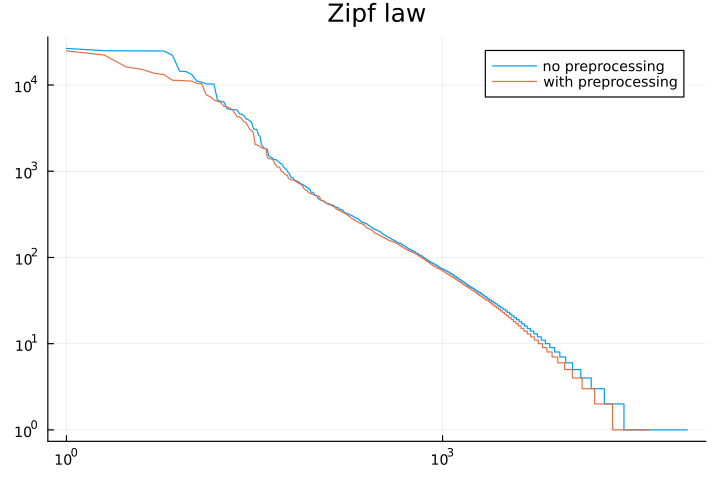

In [5]:
function zipf(V1, V2, label1, label2)
    plot(sort(V1.model.voc.ndocs, rev=true); label=label1)
    plot!(sort(V2.model.voc.ndocs, rev=true); label=label2)
    plot!(xscale=:log10, yscale=:log10, legend=true, title="Zipf law", fmt=:png, dpi=120)
end

uninopre = text_model_and_vectors(D.corpus, group_usr=false, group_url=false, group_num=false, del_diac=false, lc=false)
@show uninopre.model

unipre = text_model_and_vectors(D.corpus, group_usr=true, group_url=true, group_num=true, del_diac=true, lc=true)
@show unipre.model

zipf(uninopre, unipre, "no preprocessing", "with preprocessing")

## Ley de Heaps

Esta ley indica la rapidez de crecimiento del vocabulario con respecto al tamaño de la colección. Dicho crecimiento es sub-lineal y esta denotada por la expresión

$$ |V| \sim \gamma n^\beta $$


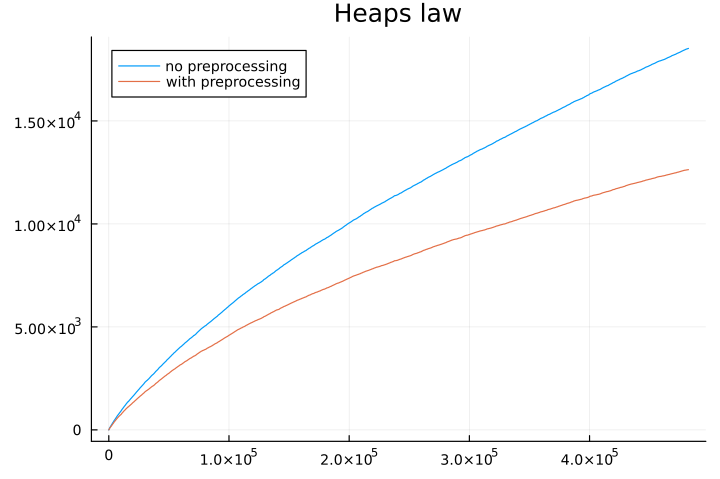

In [6]:
function heaps_(corpus, model)
    S = Set{UInt32}()
    X = [0]
    Y = [0]

    for text in corpus
        # tokens = tokenize(config, text)
        finaltokens = keys(vectorize(model, text))
        union!(S, finaltokens)
        push!(X, X[end] + length(text))
        push!(Y, length(S))
    end
    
    X, Y
end

function heaps(corpus, V1, V2, label1, label2)
    X, Y = heaps_(corpus, V1.model)
    plot(X, Y, title="Heaps law", label=label1)

    X, Y = heaps_(corpus, V2.model)
    plot!(X, Y, label=label2, fmt=:png, dpi=120)
end

heaps(D.corpus[1:3000], uninopre, unipre, "no preprocessing", "with preprocessing")


#### Los parametros $\alpha$, $\beta$, $\gamma$ permiten ajustar la expresión a una colección. Pueden llegar a ser usados para identificar una colección o incluso un lenguaje.

In [7]:
function compare(D, Q, V1, V2, label1, label2, title, n=3000)
    Q1 = vectorize_corpus(V1.model, Q.corpus)
    invfile1 = WeightedInvertedFile(length(V1.model.voc))
    append_items!(invfile1, VectorDatabase(V1.vectors))

    Q2 = vectorize_corpus(V2.model, Q.corpus)
    invfile2 = WeightedInvertedFile(length(V2.model.voc))
    append_items!(invfile2, VectorDatabase(V2.vectors))

    GC.enable(false)
    t1 = @elapsed I1, _ = searchbatch(invfile1, VectorDatabase(Q1), 15)
    t2 = @elapsed I2, _ = searchbatch(invfile2, VectorDatabase(Q2), 15)
    GC.enable(true)
    
    P1 = zipf(V1, V2, label1, label2) 
    P2 = heaps(D.corpus[1:n], V1, V2, label1, label2)
    P = plot(P1, P2, fmt=:png, dpi=120) # |> display
    s1 = scores(Q.labels, knn(I1, D.labels))
    s2 = scores(Q.labels, knn(I2, D.labels))
    m1 = Base.summarysize(invfile1) / 2^20
    m2 = Base.summarysize(invfile2) / 2^20
    
    @htl """
    <h1>$title</h1>
    <div>$P</div>
    <hr/>
    <div>$label1: $(V1.model), mem: $m1</div>
    <div>search time: $t1, scores: $s1</div>
    <hr/>
    <div>$label2: $(V2.model), mem: $m2</div>
    <div>search time: $t2, scores: $s2</div>
    """
end

compare (generic function with 2 methods)

<h1>Preprocessing effect</h1>
<div><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAHfCAIAAAD2i3iDAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdZ0BT19sA8OdmkbD3likgQ1laQEVRcO+99wCtq65qHVSttdqqrdXa1qp1j7pXFUFx721xgiiy98q+974fbps3f0RFSEhInt+n5OTk3CfJzc2Tc889h6BpGhBCCCGE1Iml6QAQQgghpPs4mg4AqZhEInnz5g0ANG7cmCCIujcoFApzcnIAwNra2tTU9H3VMjIyxGKxjY2Nubl53TeKEEKq9erVK7lc7ujoaGRkpOlY9BSBp1S0VmFh4cGDB2tYedSoUQYGBgBw7969kJAQACgvLzc2Nq711kmS/Pbbb3/99desrCymZMOGDZMnT35f/dDQ0Lt37/7444/Tp0+v9UYRQmpy8uTJvLw8V1fX9u3bV1vh+fPnV65cAYDhw4dzudz6ja4+2Nra5ufnHzx4sG/fvpqORU9hD4f2ysjIiI2NrWHlAQMGMAmHqnz33XeLFy8GgKCgIGtrawBo1KiRCttHCNWn5cuXX7t2rXfv3u9LOJKTk5kDTt++fc3MzOo3OqQXMOHQXubm5gMGDPhABaFQePLkSQCwsrLi8/mKZ/Xu3RsAOJw6fbgbNmwAgBUrVsybN68u7SCEEEKACYc2c3Nz279///sepWl66NChAMBms3fu3CkQCJhyd3f3w4cP13HTRUVF2dnZANC1a9c6NoUQQggBJhwN18qVK/fu3QsAq1ev7ty58yc9lyTJnJyc8vJyV1dXRaairLKykrmhqtFVIpHo7du3BEE4ODjgiC2EGqjs7OySkhJTU1MnJ6cP1xSLxZmZmRRFOTg41HAwmVgsfvv2LZfLdXZ2ZrPZH6hZUlKSk5NjYmKi3LlbR0Kh8M2bNzwez8nJSbWnp5ECXhbbICUkJCxcuBAARowYUWWQ5pMnT7y8vLy8vIRCoaLw6NGjnp6erVu3pml6zZo1rq6uzs7Ovr6+FhYWw4YNYzozGDdu3GBqMnfbtWvn6enp6enZrVu3WsR57ty5iRMnuri4GBoaent7e3l5mZubt2nT5uzZs1VqdunSxdPTc9euXcqFd+7cYbY+d+5c5XKxWNykSRNPT8/79+/XIiqE0CcpLi6eN2+es7Ozo6Ojn5+fs7Ozi4vLd999J5VKq9S8dOnSpEmT3N3dBQJB48aNvb29zc3NIyIiTpw48W6zn3/+uaen55IlS4qKisaMGWNhYeHl5eXm5ubk5LRixQq5XF6lfm5u7oQJEywsLCwsLHx9fZ2dnQUCQdOmTePj42v90o4ePTpixAg7OzsjIyNfX19PT09TU9POnTvfvHlTuRpN0yEhIZ6enufOnVMuP3HiBHOMWrNmjXJ5RkYGU85c4of+RaOG5tmzZ8ylpyEhIUKhsMqjd+/eZT7Z8vJyReGOHTsAoFGjRlOmTAEAZ2fnLl26tGjRgrlu1s3N7e3bt0zN69eve3h4uLi4MI00atTIw8PDw8Oja9euH46KuTTmxx9/VC5khqcZGBh4e3u3a9euWbNmzN8RgiA2bdqkXJO5/mXw4MHKhcuXL2fCcHV1VS5PTEwEAGNjY6lUWqO3DCG9FxERAQC9e/d+X4XffvuN+bqVlJQol798+dLT05P52rq5ubVp08bV1ZWp2bFjR4lEoly5Z8+ezFfey8srKioqMDDQ0NCQee5PP/1UZYv9+vUDgNGjRzdp0oQ5oHXp0sXNzY1pfODAgRRFKSoXFxe7u7szTQUFBXXt2rV169ZMJI0aNarJO2BjYwMABw8eVC709vYGAIFA4Ofn1759ez8/P2b0G4/HO3HixLsvbc6cOcqFcXFxTLRt2rRRLt+6dSsAeHp61iQw/YEJRwNTVlbm7+8PAPb29hkZGe9W+EDCwXyRli1bRpIkU37z5k1bW1sA6Ny5s3IjzEweAPDy5csaBlZtwhEfH79v3z7lQ1JeXt6YMWOYb3hOTo6i/NChQwBga2urfIhh8hXmFIxyJPPnzweAj+ZACCGF2iUcQqEwICCAyQZSUlIU5RcuXGAuXvvqq6+UG1m+fPmuXbtEIpGipLCwcNKkSQDA5XJfv36tXJlJODgcjrm5+cWLF5lCiqJ+/PFH5r/Qr7/+qqj87bffMrnF06dPlRt5/vx5lcPO+1SbcMyYMePEiRNyuVxRkp6ezuQWdnZ2yi/kp59+AoDg4GDlpzP5ipGREY/HUz7kDh8+HAAmTpxYk8D0ByYcDQlJkj169GC+uorvZxUfSDiYPw1V6jPXuQDA7du3FYWqSjiqRVFUcHBwlcrFxcXMWdv79+8zJSKRiM/nm5iYfP755wDw22+/KSq3aNECAFavXl3D2BBCTMLBZrMN34PH472bcKxfvx4AbGxs8vPzqzR45MgRADAxMVE+1LxPq1atAGD58uXKhUzCAQC7d++uUn/ChAlM16bi39GgQYPe7WD4JNUmHNUSi8WOjo5VKj9+/BgAWCxWXl4eU/L69WsA8PHxYV7IqVOnFJWZMS779u2rdbQ6CcdwNCSLFy8+fvw4AGzYsCEyMrIWLUydOrVKSdeuXb28vACg7te21BBBEFFRUQBw69YtRaG5uTmThSQlJTElly9fFovFUVFRzJBYRXlJSQmTVEVHR9dPwAjpDJIkhe/x7oAMANi5cycADB48mOnPUNazZ09TU9Py8nJmurAPa9euHQBUGRjBsLOzGzhwYJXCadOmAcDr168V/6CYAO7evUtR1Ec3V0cGBgYtW7aE/w3Yz8/PwcGBoqjz588zJcxBKTo6mjkWKY5RKSkpmZmZBEEwrxop4FUqDcbhw4eZTsXPP/+cSf9rITAwsNrCFy9eqGkA5ps3b3bu3Hn9+vWsrKzS0lLmYFFSUgIA+fn5yjWjo6Nv376dlJQ0c+ZMUPoyt23blsvlJiUlURTFYrGSk5NJkrSysmratKk6AkZIh3Xu3PmPP/6o9qFdu3Z9+eWXyiUymezOnTsAYGhoyAycqsLW1rasrOzFixedOnVSFGZlZe3YseP69esZGRmKr3xpaSm885VnBAQEvHtNip+fH5fLlclk9+/fb968OQD06NFjw4YNSUlJAQEBw4cPj46ODgkJUcmMqE+fPt29e/etW7fy8/OLi4uZwoKCAgDIy8tTVGMSiN27dyclJTEZkuIYxRyLFG8RUx4YGMj0qSAFTDgahidPnowePZqm6datW1cZDl1z5ubmJiYm75YzU4hWeyyoo02bNk2bNk0sFjN3jY2NLSwsFMcIRTkjOjp65cqVFy5ckEqlPB6P+dLGxMSYmJi0aNHi6tWrDx8+DAoKUnzJWSzsn0Po0/D5/Pdd0fruKkhFRUUymQwAVq5cuXLlyve1ySQTjJ07d8bGxioukfvwV57h7Oz8biGLxXJ2dn716hXzww8AnTp1+v777xctWvTkyZMFCxYsWLDAzMysU6dO48aN69ix4/ti+6ilS5cuW7ZMcUWMqamphYWFIgGSSCTKlaOjo5mEg7mbnJzMZrOjoqIsLS1dXV0fPnyYm5trZ2enOEbVOipdhQlHA1BUVNSjR4+ysjIXF5eDBw8qTrV+qncvM2OQJAkAH77wvRZu374dFxdHUdSECRPGjx8fEhKimPx02bJlzLzpyiIjI/l8fmVl5c2bNwMCAu7evWtnZ+fn5wcAMTExV69eTUpKCgoKYv5G4JcZIXWj/1tpKzY2lrlCpFqK07spKSljxoyRy+UjR46MjY1t0aKFItVYs2bNrFmzqn36+06RMMcr5ePS7Nmzhw4devTo0VOnTl2+fLmkpGT//v379+8fPXr05s2ba/EP5OjRo/Hx8SwWa+7cucOGDfP391dsbuLEiZs2bapSPyYmBgBSU1NfvXolEokyMzNbtGhhaWkJAO3bt9+6dWtycnL//v0vXrwIeIyqDiYc2o4ky
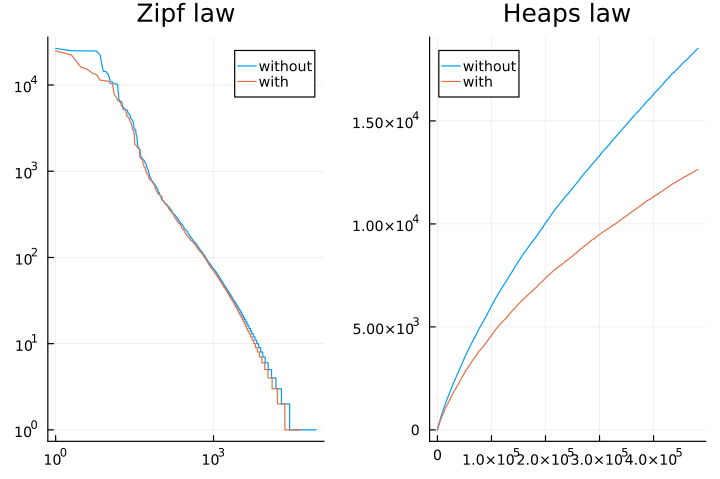

In [8]:
compare(D, Q, uninopre, unipre, "without", "with", "Preprocessing effect")

## Preprocesamiento y toquenizado

Ya se ha mostrado el efecto en el vocabulario de normalizar usuarios, urls, números, capitalizado, etc. Ahora veremos el efecto de usar otros esquemas que enriquecen o filtran el vocabulario.

### Unigramas, Bigramas, Q-gramas, Skip-grams

Los unigramas son las palabras que normalmente usamos, bigramas es la concatenación de 2 unigramas contiguos. El concepto se puede extender a múltiples palabras, en adelante los llamares n-words. Algunos problemas funcionan mejor usando subcadenas de caracteres, que aquí llamaremos q-grams, estos estan recomendados para capturar características de estilo y también cuando hay una gran cantidad de errores de ortografía. Los skip-grams son bigramas no contiguos, i.e. saltan palabras, también se pueden generalizar a varios números y tipos de saltos. En el caso de n-words y skip-grams, son notablemente buenos cuando se requiere capturar contexto del texto, i.e., reducir problemas por homonimia o simplemente cuando es deseable que los tokens sean más específicos en su significado.


<h1>Effect of tokenization</h1>
<div><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAHfCAIAAAD2i3iDAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdd1xTV/sA8HMz2GElbJANooKtG1RQwYGKeysWrIrbOurAra+72tqq1aq1Vq1bBPfAvcWBWxmKDAGBEEZCSHLv74/z9v7yhiE7ueH5fvrpJ/fek3Of4E3y5NwzCIqiEAAAAABAfWKpOwAAAAAAaD+OugMA9UImk338+BEh5OLiwmaza1+hRCL5/PkzQsjc3NzU1LSiYmlpaRKJRCAQmJmZ1f6kAABQe0lJSSRJ2tnZGRgYqDuWRo2AWyoaTiQSHTlypIqFR40aZWRkhBBKSEjw8PBACGVmZlpZWdX47BRFbdy4cevWrampqXjP+vXr582bV1F5f3//W7du/ec//1m0aFGNTwoAqEPR0dF5eXlubm6dO3cut8Dr168fPHiAEAoLCyMIomGjawgGBgYSieTChQs9e/ZUdyyNGrRwaLrs7OyIiIgqFg4ODsYJR13ZsmXL/PnzEULe3t44cXFycqrD+gEA9W3p0qXPnz8fM2ZMRQnHxYsXZ8+ejRAaO3ZsnTSIAlAuSDg0nZGR0dChQyspIJVKT58+TVGUsbExj8ejnzVgwACEkJ6eXm3Ovn37doTQokWL/vOf/9SmHgAAAI0cJByazsbG5ujRo5UUmDhxIkVRLBbrwIEDdO8KGxubqKioWp66tLQ0ISEBIdS7d+9aVgUAAKCRg4SD2bZu3bpr1y6E0MqVK0NCQqr1XJIkMzMzCwoKHBwcDA0NyxYoLi7GD8o9WgMlJSXp6ekkSdrY2NTtrR8AQP2hKOrz588ikcjU1NTGxqbywhKJJC0tjSAIGxubKn50SCSS1NRUfX19Ozs7FquysZN5eXnZ2dnGxsZ8Pl9XV7car6FiRUVFqampenp6dnZ2Ojo6dVInKBcMi2Ww27dvz5kzByE0cODAyMhI5UMpKSnu7u7u7u65ubn0zkuXLrm6urZq1YqiqO3btzs7O9vZ2Xl5eZmbmw8dOpTuFooQev78OS6JN/v27evq6urq6tq1a9caxHnr1q3Jkyc7Ozvr6+u7ubl5eHiYmpr6+vqeOXNGpeSQIUNcXV1xCkV7/fo1Pvu0adOU98vlcm9vb1dX1zt37tQgKgDAV+Xk5MyePdvW1tbOzq5Zs2a2trbOzs6bN2+Wy+UqJa9evTpx4sQmTZoYGBh4eHi4u7ubmpr6+/tfvny5bLVhYWGurq4bN27Mzs4eNWqUmZmZp6dnkyZNHBwcNm/erFAoVMqnp6eHhYWZmJjw+XwvLy87Ozt9ff1vvvlm7dq1NX5px44dGzVqlIWFBY/Ha9asmYuLi4mJSUhIyNOnT5WLyWSy5s2bu7q63r9/X3n/0aNH8efSjh07lPe/f//e1dXVzc1NJBLVODatRQFmSklJsbS0RAj5+PgUFRWpHH3//j3+983MzKR3njx5EiFkZma2YMEChJCNjU1wcHD79u3xTwpbW9ukpCRcMj4+3sXFhe4fam9v7+Li4uLi0qVLl8qjwr3S/vOf/yjv7NevH0JIV1fX3d29S5cuLVu2xIPTCILYsmWLckk8/iUkJER55y+//ILDsLS0JEmS3n/v3j2EkI6OTtmXDwCg+fj4IITGjBlTUYHNmzfjt5hcLlfe//r1awcHB4QQi8Vydnb29/fHmwihfv36qRTu1q0bfpt7eHh07drVx8cHdyAjCGLXrl0qZ8SjRSIiIpydnQmCaNOmTXBwMF15WFiYcuGsrCx7e3scRqtWrXr37t2xY0dc2MvLqyp/AX19fYTQhQsXlHfa2toihAwNDZs3b96tWzcvLy8Oh4MQ0tPTu3LlStmXtmzZMuWdoaGhONrg4GDl/Vu3bkUItWzZsiqBNTaQcDCSWCxu06YNQsjc3DwxMbFsgUoSDjabTRBEZGQk/Xnx7NkzOzs7hFDnzp2Vv9Hz8vJwJc+ePatiYOUmHKtXrz548KBEIqH35ObmTp48GSHE5XJTUlLo/RcvXkQI8Xi80tJSeie+VYTbZuPj4+n9uB+rv79/FWMDoHGqWcJRUFDg5uaGEPL19X3//j29/9KlS7iv2Jo1a5QrWbZs2ZEjR6RSKb0nOzs7PDwcIaSvr6/8QUT9m3BwOBwLC4sHDx7gnQqFYvXq1TiSAwcO0IVx862rqyv9iwh7/fr11q1bq/IXKDfhmDp16sWLFxUKBb0nMTGxR48eCKEmTZrIZDJ6/5o1axBCnTp1Un46vvujr69vaGio/KoHDhyIEJo9e3ZVAmtsIOFgHpIkR44ciVOH8+fPl1umkoQDIdSnTx+V8tevX8eHrl+/Tu+sq4SjIh07dkQIrV69mt5TXFyM78veuXMH75HJZCYmJnp6enjY3ubNm+nC+P7OihUrqhgbAI0TTjjYbLZBBeiOC8oJx7p16xBCdnZ2+fn5KhUeOHAAIcTn80tKSio/NUmS3377LULol19+Ud5Pz4cRExOj8hT84abcdNGnT59avtPLTTjKVVRUxOfzVQrjmykcDkckEuE9r1+/Rgi1atWqV69eCKEbN27g/XK5HM95ePbs2RpHq8WgDwfzrF+//tChQwihTZs24cu9uqZPn66yJyAg4JtvvkEI1X5sS9XhjOHhw4f0HgMDgw4dOiCErly5gvc8evRIJBL5+fn17dsXIRQbG4v3l5SU4FsqgYGBDRYwAMylUCjEFSgtLS1bHmcVoaGhJiYmKoeGDRumo6OTm5sbFxdX+UkJgujSpQtC6NGjR2WPOjs74/e1shkzZiCE3rx58/btW7xHIBAghB4/fkzV/zSVhoaG7dq1Q/8bcJs2bczMzORy+e3bt/Ee/EEUGBiIP3/oz6UnT54IhUIOh9OpU6f6DpWJYJQKw1y6dGnx4sUIodDQ0JkzZ9asEvyLR8U333zz7NmzZ8+e1Sq+CmRkZOzfv//+/fupqakikYgkSYQQ7lT15csX5ZKBgYE3btyIjY1dunQpUnpjd+zY0dDQ8MaNGzKZjMvl3rp1q6SkhMfj4U8HAEDlBg8evGXLlnIP7dq1a8WKFcp7CgsL8Y94XV1dOvtXZmlpmZaWlpCQgNspsU+fPh04cOD+/fsZGRn02zw/Px+VeZtjPj4+ZSc2bdmyJUEQFEU9ffq0adOmCKF+/frt27cvJiamZcuWo0ePDgwM/Oabb3B/i1p6+fLloUOH4uLicnJycJwIoezsbPr/GJvN9vf3j46Ojo2NxXME0J9LeDrE2NhY/AfE+9u3b29sbFz78LQPJBxM8v79++HDhysUilatWu3cubNmlejo6JQ72TnuhFXu50ItHThwICIiQiwW400jIyMzMzMul4s3S0pKlAsHBgYuXbr0/v37RUVFRkZG+A0cFBSko6Pj5+d3+fLlBw8edOrUCe/39/en6wEAVAIPOi33UNk2jC9fvuB0QSURUaE8EGPXrl0zZsyg386Vv80x3BW0bJwWFhbZ2dk5OTl4z6BBg1auXLlq1aoXL17gDu9mZma9evWaOHEibj6pAYqiFi1atH79evwyEUImJiZmZmb0oFypVKpcPjAwMDo6GudeCoXixo0bOjo6nTp1MjAwwN1QCgoKjI2N6USkZlFpPUg4GKOwsHDQoEH5+fnW1tbR0dH4rmQNkCRJkmTZwe54KFqdT2z8+vXr8PBwuVw+duzYiIiItm3b0p9BmzdvxsN6lbVr187Y2LigoOD27dtdunS5f/++qalp69atEUKBgYGXL1+OjY2lEw54YwNQH+ibFzNmzMCjOcrl5+eHH8TFxU2aNIkkyQkTJowfP75Vq1Z0C8SqVatwa2VZ9Je9CjzmVvmzaMmSJWFhYadOnbpw4cKtW7eEQuGhQ4cOHz48efLkrVu31mD9l0OHDq1du5bD4SxcuHDkyJFeXl70R+Lo0aP/+ecflfL
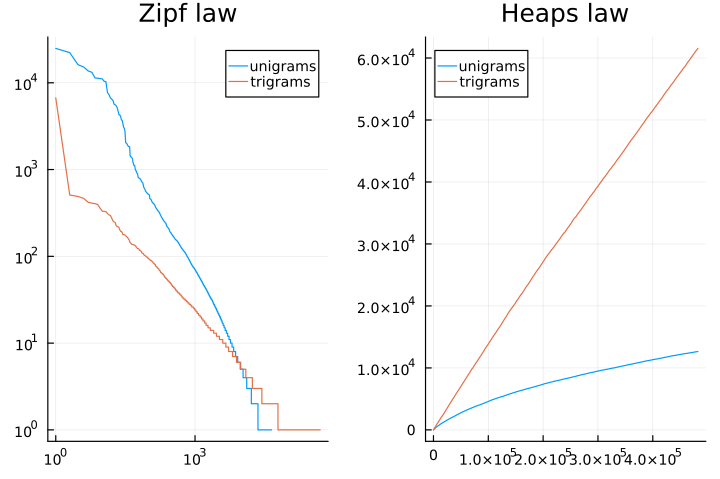

<h1>Effect of tokenization</h1>
<div><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAHfCAIAAAD2i3iDAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdd1gTWdsw8DOTAgESCL0ICgiCCChiA1QU7GJBQUVXsSAqa+8iuva6rrquBXVd17biqohrQ3FVrI+9oVJEeocQSELqfH/M++TLA6iUhAS4f9deeyUzJ2fuxMnk5swpGEEQCAAAAABAlXB1BwAAAACAlo+q7gCASojF4i9fviCE7OzsKBRK4ysUCAR5eXkIIUNDQwMDg68Vy87OFggExsbGbDa78QcFAIDGS0tLk8lkVlZWOjo66o6lVcPgloqGKy8vP3v2bB0Lh4SE6OnpIYRSUlIcHR0RQvn5+WZmZg0+OkEQO3bs2LdvX1ZWFrll27Zty5Yt+1r5Pn36JCYmbty4MTIyssEHBQAo0aVLl0pLS9u3b9+7d+9aCyQlJT158gQhFBoaimFY00bXFHR0dAQCwfXr1wcNGqTuWFo1aOHQdIWFheHh4XUsPGTIEDLhUJY9e/YsX74cIeTq6komLu3atVNi/QAAVVuzZs2bN28mTZr0tYTjxo0bixYtQghNnjxZKQ2iANQKEg5Np6enFxQU9I0CQqHw8uXLBEGwWCwmkyl/1ahRoxBC2trajTn6/v37EUKRkZEbN25sTD0AAABaOUg4NJ2FhUVMTMw3CsycOZMgCBzHT548Ke9dYWFhcfHixUYeWiQSpaSkIISGDh3ayKoAAAC0cpBwNG/79u07fPgwQmj9+vUBAQH1eq1MJsvPz+dyudbW1rq6ujUL8Hg88kGtexugqqoqJydHJpNZWFgo99YPAEB1CILIy8srLy83MDCwsLD4dmGBQJCdnY1hmIWFRR0vHQKBICsri8FgWFlZ4fi3xk6WlpYWFhayWCwjIyMtLa16vIevq6yszMrK0tbWtrKyotPpSqkT1AqGxTZj9+/fX7x4MUJo9OjRq1atUtyVkZHh4ODg4OBQUlIi3xgfH29vb+/h4UEQxP79+21tba2srJydnQ0NDYOCguTdQhFCb968IUuST4cPH25vb29vb9+vX78GxJmYmDh79mxbW1sGg9G+fXtHR0cDA4NevXr9888/1UqOHTvW3t6eTKHkkpKSyKP/+OOPitslEomrq6u9vf2DBw8aEBUA4LuKi4sXLVpkaWlpZWXVsWNHS0tLW1vbXbt2SSSSaiVv3749c+ZMGxsbHR0dR0dHBwcHAwODPn363Lx5s2a1oaGh9vb2O3bsKCwsDAkJYbPZHTp0sLGxsba23rVrl1QqrVY+JycnNDRUX1/fyMjI2dnZysqKwWB07tx5y5YtDX5r586dCwkJMTExYTKZHTt2tLOz09fXDwgIePnypWIxsVjs4uJib2//+PFjxe0xMTHkdengwYOK25OTk+3t7du3b19eXt7g2FosAjRPGRkZpqamCCE3N7fKyspqe5OTk8l/3/z8fPnGCxcuIITYbPaKFSsQQhYWFkOGDOnRowf5J4WlpWVaWhpZ8vXr13Z2dvL+oW3atLGzs7Ozs/P19f12VGSvtI0bNypuHDFiBEJIS0vLwcHB19fX3d2dHJyGYdiePXsUS5LjXwICAhQ37t69mwzD1NRUJpPJtz969AghRKfTa759AICcm5sbQmjSpElfK7Br1y7yKyaRSBS3JyUlWVtbI4RwHLe1te3Tpw/5FCE0YsSIaoX79+9Pfs0dHR379evn5uZGdiDDMOzw4cPVjkiOFgkPD7e1tcUwzNPTc8iQIfLKQ0NDFQsXFBS0adOGDMPDw2Po0KHe3t5kYWdn57p8AgwGAyF0/fp1xY2WlpYIIV1dXRcXl/79+zs7O1OpVISQtrb2rVu3ar61tWvXKm784YcfyGiHDBmiuH3fvn0IIXd397oE1tpAwtEs8fl8T09PhJChoWFqamrNAt9IOCgUCoZhq1atkl8vXr16ZWVlhRDq3bu34i96aWkpWcmrV6/qGFitCcemTZtOnTolEAjkW0pKSmbPno0QotFoGRkZ8u03btxACDGZTJFIJN9I3ioi22Zfv34t3072Y+3Tp08dYwOgdWpYwsHlctu3b48Q6tWrV3Jysnx7fHw82Vds8+bNipWsXbv27NmzQqFQvqWwsHDq1KkIIQaDoXghIv6bcFCpVBMTkydPnpAbpVLppk2byEhOnjwpL0w239rb28v/IiIlJSXt27evLp9ArQlHRETEjRs3pFKpfEtqaurAgQMRQjY2NmKxWL598+bNCCEfHx/Fl5N3fxgMhq6uruK7Hj16NEJo0aJFdQmstYGEo/mRyWQTJkwgU4dr167VWuYbCQdCaNiwYdXK37lzh9x1584d+UZlJRxf4+3tjRDatGmTfAuPxyPvyz548IDcIhaL9fX1tbW1yWF7u3btkhcm7++sW7eujrEB0DqRCQeFQtH5CnnHBcWEY+vWrQghKysrDodTrcKTJ08ihIyMjKqqqr59aJlM1qVLF4TQ7t27FbfL58OIi4ur9hLy4qbYdDFs2LBGftNrTThqVVlZaWRkVK0weTOFSqWWl5eTW5KSkhBCHh4egwcPRgjdvXuX3C6RSMg5D69cudLgaFsw6MPR/Gzbtu3MmTMIoZ9//pk83etr7ty51bb07du3c+fOCKHGj22pOzJj+M9//iPfoqOj07NnT4TQrVu3yC1Pnz4tLy/38vIaPnw4QighIYHcXlVVRd5S8fPza7KAAWi+pFIp/ytEIlHN8mRW8cMPP+jr61fbFRwcTKfTS0pKnj179u2DYhjm6+uLEHr69GnNvba2tuT3WtG8efMQQh8+fPj48SO5xdjYGCH0/PlzQvXTVOrq6nbv3h39b8Cenp5sNlsikdy/f5/cQl6I/Pz8yOuP/Lr04sWLsrIyKpXq4+Oj6lCbIxil0szEx8evXr0aIfTDDz/Mnz+/YZWQf/FU07lz51evXr169apR8X1Fbm7uiRMnHj9+nJWVVV5eLpPJEEJkp6qioiLFkn5+fnfv3k1ISFizZg1S+GJ7e3vr6urevXtXLBbTaLTExMSqqiomk0leHQAA3zZmzJg9e/bUuuvw4cPr1q1T3FJRUUH+Ea+lpSXP/hWZmppmZ2enpKSQ7ZSkzMzMkydPPn78ODc3V/4153A4qMbXnOTm5lZzYlN3d3cMwwiCePnypZOTE0JoxIgRx48fj4uLc3d3nzhxop+fX+fOncn+Fo307t27M2fOPHv2rLi4mIwTIVRYWCj/P4lCofTp0+fSpUsJCQnkHAHy6xI5HWJCQgL5AZLbe/TowWKxGh9eywMJR3OSnJw8btw4qVTq4eFx6NChhlVCp9Nrneyc7IRV63WhkU6ePBkeHs7n88mnenp6bDabRqORT6uqqhQL+/n5rVmz5vHjx5WVlXp6euQX2N/fn06ne3l53bx588mTJz4+PuT2Pn36yOsBAHwDOei01l012zCKiorIdKFaIlKN4kCMw4cPz5s3T/51/vbXnER2Ba0Zp4mJSWFhYXFxMbklMDBw/fr1GzZsePv2Ldnhnc1mDx48eObMmWTzSQMQBBEZGblt2zbybSKE9PX12Wy2fFCuUChULO/n53fp0iUy95JKpXfv3qXT6T4+Pjo6OmQ3FC6Xy2Kx5IlIw6Jq8SDhaDYqKioCAwM5HI65ufmlS5fIu5INIJPJZDJZzcHu5FA0pU9snJSUNHXqVIlEMnny5PDw8G7dusmvQbt27SKH9Srq3r07i8Xicrn379/39fV9/PixgYFB165dEUJ+fn43b95MSEiQJxzwxQZAFeQ3L+bNm0eO5qiVl5cX+eDZs2ezZs2SyWRhYWEzZszw8PCQt0Bs2LCBbK2sSf5jXw055lbxWhQVFRUaGhobG3v9+vXExMSysrIzZ8789ddfs2fP3rdvXwPWfzlz5syWLVuoVOrKlSsnTJjg7OwsvyROnDj
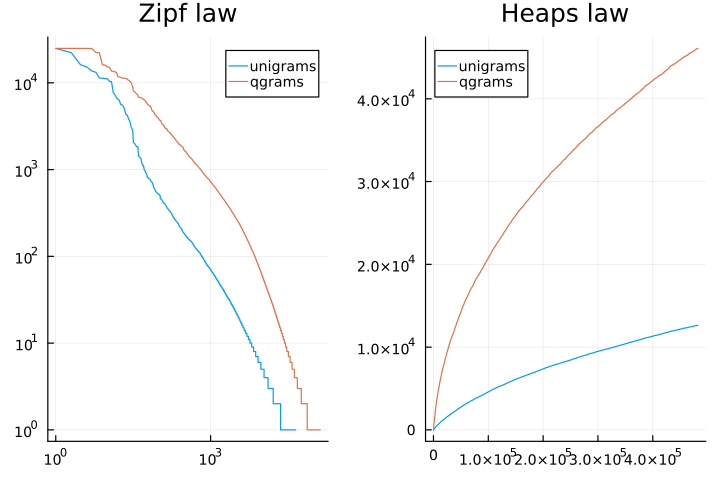

In [10]:
unimodel = text_model_and_vectors(D.corpus, group_usr=true, group_url=true, group_num=true, del_diac=true, lc=true, nlist=[1])
bimodel = text_model_and_vectors(D.corpus, group_usr=true, group_url=true, group_num=true, del_diac=true, lc=true, nlist=[3])
compare(D, Q, unimodel, bimodel, "unigrams", "trigrams", "Effect of tokenization") |> display

qmodel = text_model_and_vectors(D.corpus, group_usr=true, group_url=true, group_num=true, del_diac=true, lc=true, qlist=[4])
compare(D, Q, unimodel, qmodel, "unigrams", "qgrams", "Effect of tokenization")


### Lexemas o raices (stemming)

Las raices de las palabras se usan para generalizar el contenido de los mensajes, y también reducir el tamaño del vocabulario. Las raices se producen mediante reglas para cada idioma que por lo general consisten en remover sufijos. En particular, para el ejemplo usaremos el algoritmo snowball. Además de que podría no ser adecuado para algunos problemas, los algoritmos de stemming pueden producir colisiones de palabras no relacionadas. Por reglar general, el desempeño y la configuración adecuada dependerán del problema.

### Lematización (lemmatization)
La lematización es un método que evita producir colisiones haciendo que la reducción no sea basada en reglas de reducción de sufijos, sino que la palabra es reducida a otra palabra válida. Los lemas validos y el árbol de los mismos suele ser creado por expertos lingüistas.



<h1>Stemming effect</h1>
<div><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAHfCAIAAAD2i3iDAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdd1wUx9sA8LlCOeDovYh0kCqIRFFEioIlaiIqasQOEntvQWMvsccSsXejooJGUbCjAiqCiaJIL1Ll6FzZ3feP/WXfCyhNYA94vh//4GbnZp9b93af252ZZRAEgQAAAAAA2hKT7gAAAAAA0Pmx6Q4AtLKampqcnBwGg2FqatoqDVZUVBQVFSGENDU1FRQUvlYtIyNDKBRqa2tzudxWWS8AALSizMxMgUCgpaWlqKhIdyxdFANuqUisvLy8GzduNLHyzJkzyT/u3bvn6ekpJSUlEAi+Ze0CgSAkJOT48eOFhYVkyfnz58eNG/e1+kZGRhkZGadOnfrpp5++Zb0AgLYQFRWVnZ2to6Pj4+PzxQqZmZn37t1DCPn5+TXw06LjsrS0fP/+fWho6PTp0+mOpYuCKxySKzk5OTAwsImVqYSjtaxYsWLnzp0MBsPJyUlFRQUhpK2t3bqrAAC0m927d9+8eXPAgAFfSzji4+OnTp2KEBo4cGCnTDgA7SDhkFyampp+fn4NVODxeHfv3kUI6enpUYUaGhojR46UkpL6llWLRKLDhw8jhA4ePNj0pAcAAAD4Gkg4JJeNjc2ff/75taU4jn///fcIIVlZ2bCwMKrc1tb26tWr37jqzMzMyspKhNCQIUO+sSkAAAAAQcLRca1YseLmzZsIod9//713797Neq9IJMrPz6+qqurevbuMjEz9ClVVVeQfrXVltbq6Ojs7m81m6+npycrKtkqbAIB2VlBQ8PnzZy6Xq6enx2AwGqjJ5/Pz8vKEQqGWlpaSklJTGufz+bm5uQwGw8DAgM1u6NxUXl6el5enoKCgpqbG4XCa9xm+oqamJjs7m8lk6unptVaboA4YFtshXblyZfv27QihBQsWTJs2TXzR8+fPzczMrK2txQtPnjxpYmIydOhQDMPWr1+vp6dnYGBgaWmpqqo6ffr0kpISqmZkZCRZk3zp6OhoYmJiYmIyfvz4FsR58+bNKVOm6OjoyMvLW1pampqaKioqent7P3nypE5NV1dXExOTOp1ko6OjybVv3LhRvLy4uJgsT09Pb0FUAIBmqaysXLt2bffu3bW1tXv06GFgYKCrq7tmzZqampo6NePj4+fOnWtubi4rK2tsbGxhYaGqqurk5HTx4sX6za5cudLExGThwoUVFRWzZs1SV1c3MTExNjbW0tL65Zdf+Hx+nfqlpaVz5szR0NBQUlKysrIyMDCQk5OztLRctGhRiz9aZGTktGnT9PT05OTkLCwszMzMFBUVPTw8Hjx4UKemu7u7iYlJnevHjx8/Jo9Fa9asES8vKyszNTU1MTF5//59i2PrhAjQ0bx+/VpeXh4h5OnpKRQK6yyNjo5GCElJSYkX7tmzByFkZ2c3YcIEhJCRkZGvr2/Pnj3JfaBHjx7FxcVkzdu3bxsbG+vr65OLunfvbmxsbGxs7O/v33BU3bt3RwidOnVKvNDBwQEhxOFwLC0tPTw8rK2tpaWlEUJsNvvSpUviNf39/RFCwcHB4oXUccTJyUm8nLzTpKWlheN4EzYYAIAgf0UMGDDgaxUuXbpEft3S09PFy3Nzc21sbMhFBgYGbm5uxsbG5OWNPn36VFZWilcOCAhACElLSxsbGw8YMMDR0ZG6Srp27do6a5wxYwZCyM/Pr1evXgghW1tbX19fMzMzsr6Pj49AIKAqV1dXU2HY2Nj4+vr279/fyMiIyWQqKCg0ZQtYWFgghEJDQ8ULXVxcEEKysrIWFhYDBw60sbEhL/qyWKyzZ8/W/2jTpk0TL1y5ciUVknj59evXEUJqamoYhjUlti4CEo4Opri42NjYmEwFioqK6ldoIOFgs9kMBmPfvn3Uefr+/fvk1c7x48eL109MTCS/RZ8/f25iYF9MOJYsWXLt2jXxrCgnJ4fsCausrFxeXk6VHzlyBCFkbm4u/nYyJZKXl2cymVRKRBAE2Y91woQJTYwNANCyhEMoFPbp0wchZGVl9erVK6o8Pj6e/FkSFBQk3siuXbuOHTsmnoWUl5cvXboUIcRkMpOSksQrkwkHm82Wk5O7desWVX7s2DEWi4UQ2rx5M1V46NAhhJCGhoZ4GARBZGRkbNu2rSlb4IsJx4oVK8LCwsQzm7y8PPL3D5fLLS0tpcpPnz6NEDI0NBR/O5mvyMvLMxiMvLw8qnzu3LlkLtWUwLoOSDg6EoFAMHDgQISQgoJCna8upYGEo/7Rgfj3W8RgMFJSUqjC1ko4vkgoFJI5k3jljIwMco0ZGRlkSXFxMXk/ddKkSQgh8Ssi5Jxmx44da2JsAAAy4WAymXJfQXXnEk84zp07Rx5wsrKy6jT46NEj8mJGfn5+o2sfPnw4QmjRokXihWTCgRA6cOBAnfpLliwhrxDU1NSQJbNmzUIITZ8+vQWfnfTFhOOLRCKRpaVlncq5ublktNShksfjsVgsTU1NcmKPM2fOUJXJm9qHDh1qcbSdEvTh6Ejmz59///59BoNx9OhRW1vbFrQwZ86cOiX+/v6amprEv9cA2wGbze7fvz9CKD4+nio0NDQksxBy6iGEUHR0NI7jXl5enp6e5EuyPCsr6+PHjwghMvcCADQdjuPVX1G/zwRC6MyZMwihESNGGBgY1FnUv3//bt26CQQC6jvbAHd3d/TfrzxFQUFhypQpdQrnzZvHYDBKSkoeP35MlqirqyOEEhMThUJho6v7RiwWy83NDf03YF1dXSsrKyR2LHrw4AGGYR4eHl5eXuLlBQUFb9++RQiRxy5AgVEqHcbJkycPHDiAEFq1atWYMWNa0IK0tDSZtotjsVg2Njb37t17/fp1K0RZz8ePH8+ePRsXF1dQUFBaWkoWkt1UqTlMSZ6enmlpadHR0eTRh/z2enp6kl/aqKgoshr5h5mZGXlNBQDQdH369KFundRx8+bN+pPuPH/+HCGkpKREfQHFqampZWVlpaSkiBcWFhaePXs2JiYmIyOjoqJCJBIhhMhh9uRDEuoge5jWKdTT01NXVy8qKkpISPD29kYIDR06dOPGjfHx8ZaWlpMmTfL29nZycvriILvmSktLO3v2bGxsbH5+Po/HIwgCIfT582f0pWPUu3fvoqOjyQ1FHaO8vLyYTOadO3fIalFRUQRBdOvWrbWeL9FpQMLRMTx79ozcxX18fNauXduyRvT09JjML1zTIn+7fPFY8I1+++23lStXUr9IFBUVlZWVqQFvdX5ReXp6hoaGkt9VBoNBfpk9PDx0dXUtLS2Tk5MzMjK6d+9OfclbPVoAOj1paWnxeQLFqaqq1ikRCoXkeffAgQPkr50vKi8vp/6+fv16QEBAWVkZ+VJOTk5FRYVKC2pra+u/vf61E1K3bt2KioqKi4vJly4uLgcPHly0aFFaWtratWvXrl0rLy8/aNCggICAESNGfC22Ru3du3fJkiXUgyC4XK6KikoDx6jff//93r17OI4zmUzqWKSmpmZra5uYmPjhwwdzc3M4Rn0NJBwdwKdPn/z8/Ph8voWFxYULF8juVC2AYVgD5S1u9muioqKWLFnCYDDmz58/adIkOzs7ahULFizYvXt3nfqenp5MJpO8GsnlclNTU3v06EEeHL28vJKTk+/duzdlypT79+8j+DID0PZwHCf/mDRpUo8ePb5WzdnZmfwjKyvL39+/pqZm9OjRP//8c9++fclRaQihEydO1L9vQvracYm8NCJ+XJo5c+aoUaOuX7/+119/PXr0qKSk5OrVq1evXh01atTFixdbML3y48eP58+fTxDE7NmzJ0+ebG9vT6Uay5cv37p1a5367u7uLBarpKQkMTFRW1v73bt3JiYmRkZGCCEvL6/ExMTo6Ghzc3M4Rn0NJBySrra2dtSoUbm5uYqKim
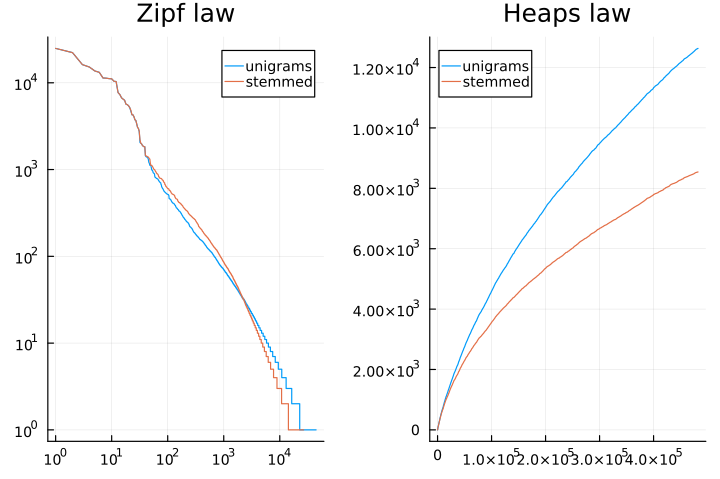

In [11]:
struct StemmerTransformation <: AbstractTokenTransformation
    stemmer::Vector
    StemmerTransformation(lang::String) = new([Stemmer(lang) for _ in 1:Threads.nthreads()])
end

function TextSearch.transform_unigram(S::StemmerTransformation, tok)
   stem(S.stemmer[Threads.threadid()], tok)
end

stemmed = text_model_and_vectors(D.corpus, group_usr=true, group_url=true, group_num=true, del_diac=true, lc=true, nlist=[1], tt=StemmerTransformation("spanish"))
compare(D, Q, unimodel, stemmed, "unigrams", "stemmed", "Stemming effect") |> display

### Remover términos comunes (stop words)
Las palabras comunes como los artículos, adverbios, preprosiciones, conjunciones, y verbos auxiliares ocurrirán en la mayoría de los documentos de una colección. Estas poblarán las listas de posteo y deberán ser consultadas por los algoritmos de búsqueda. Como aparecen en gran parte de la colección, reducen en si mismas la búsqueda a una evaluación exhaustiva. Removerlas siempre puede ser de utilidad.

<h1>Stopwords effect</h1>
<div><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAHfCAIAAAD2i3iDAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdZ1zUyN8A8Em2UJfekd5BEAVERaWrWA65UzmwnQ3sHbueZxd7L+iJZxdFAQvqYsMKCmJFkaZU6Z1tyfNinst/j16W6nw/vmBnJ5MfmE1+O5nMYCRJAgRBEARBkLaEd3QACIIgCIJ0f/SODgARsaqqqoyMDAzDDA0NRdJgWVlZXl4eAEBFRUVaWrq+amlpaTweT01NjcViiWS/CIIgIpSens7lclVVVWVkZDo6lp8Uhm6pdFpZWVk3btxoYmU/Pz/4w/37911dXRkMBpfLbc3euVzuunXrTp069ePHD1hy4cKF33//vb76enp6aWlp//zzz8SJE1uzXwRB2gKbzf7+/bu6uvqwYcPqrJCenn7//n0AwNixYxv4atF1mZqafv78OSgoaPr06R0dy08K9XB0XomJif7+/k2sTCUcorJy5crdu3djGGZjYyMvLw8AUFNTE+0uEARpN3v37r1586ajo2N9CUdsbOzUqVMBAM7Ozt0y4UA6HEo4Oi8VFZWxY8c2UKG4uPjevXsAAE1NTapQWVl59OjRDAajNbvm8/nHjx8HABw5cqTpSQ+CIAiC1AclHJ1Xz549L1++XN+7BEH88ssvAABxcfHQ0FCq3NLS8tq1a63cdXp6enl5OQBg+PDhrWwKQRAEQQBKOLqulStX3rx5EwBw8ODBvn37NmtbPp+fk5NTUVGhq6srJiZWu0JFRQX8QVQ9q5WVld+/f6fT6ZqamuLi4iJpE0GQdpabm1tYWMhisTQ1NTEMa6Amh8PJysri8XiqqqqysrJNaZzD4WRmZmIYpqWlRac3dG0qLS3NysqSlpZWVFSUkJBo3u9Qj6qqqu/fv+M4rqmpKao2kRrQY7Fd0tWrV3fs2AEAWLRo0bRp04TfevHihZGRkYWFhXDh6dOnDQwMRowYIRAINm7cqKmpqaWlZWpqqqCgMH369IKCAqrmnTt3YE34sk+fPgYGBgYGBr6+vi2I8+bNm1OmTFFXV5eSkjI1NTU0NJSRkXF3d3/y5EmNmg4ODgYGBjUGyUZFRcG9b968Wbg8Pz8flqemprYgKgRBmqW8vHz9+vW6urpqamrm5uZaWloaGhp//vlnVVVVjZqxsbHz5883NjYWFxfX19c3MTFRUFCwsbG5dOlS7WZXrVplYGCwePHisrKyWbNmKSkpGRgY6Ovrq6qqrl27lsPh1KhfVFQ0b948ZWVlWVlZMzMzLS0tSUlJU1PTJUuWtPhXu3PnzrRp0zQ1NSUlJU1MTIyMjGRkZFxcXB4+fFijppOTk4GBQY3+4+joaHgu+vPPP4XLS0pKDA0NDQwMPn/+3OLYuiES6WrevHkjJSUFAHB1deXxeDXejYqKAgAwGAzhwn379gEArKysxo8fDwDQ09Pz8PDo3bs3PAbMzc3z8/NhzcjISH19/R49esC3dHV19fX19fX1fXx8Go5KV1cXAPDPP/8IF1pbWwMAJCQkTE1NXVxcLCwsmEwmAIBOp4eEhAjX9PHxAQDMnj1buJA6j9jY2AiXwztNqqqqBEE04Q+GIAgJv0U4OjrWVyEkJAR+3FJTU4XLMzMze/bsCd/S0tIaPHiwvr4+7N7o379/eXm5cOXJkycDAJhMpr6+vqOjY58+fahe0vXr19fY44wZMwAAY8eOtbW1BQBYWlp6eHgYGRnB+sOGDeNyuVTlyspKKoyePXt6eHgMGjRIT08Px3Fpaemm/AVMTEwAAEFBQcKF9vb2AABxcXETExNnZ+eePXvCTl8ajXbu3Lnav9q0adOEC1etWkWFJFweFhYGAFBUVBQIBE2J7SeBEo4uJj8/X19fH6YCeXl5tSs0kHDQ6XQMww4cOEBdpx88eAB7O319fYXrJyQkwE9RYWFhEwOrM+EICAi4fv26cFaUkZEBR8LKycmVlpZS5SdOnAAAGBsbC28OUyIpKSkcx6mUiCRJOI51/PjxTYwNQZCWJRw8Hq9///4AADMzs7i4OKo8NjYWfi2ZOXOmcCN79uz5+++/hbOQ0tLSZcuWAQBwHH/79q1wZZhw0Ol0SUnJ27dvU+V///03jUYDAGzdupUqPHr0KABAWVlZOAySJNPS0gIDA5vyF6gz4Vi5cmVoaKhwZpOVlQW//7BYrKKiIqr8zJkzAAAdHR3hzWG+IiUlhWFYVlYWVT5//nyYSzUlsJ8HSji6Ei6X6+zsDACQlpau8dGlNJBw1D47kP9+ijAMS0pKogpFlXDUicfjwZxJuHJaWhrcY1paGizJz8+H91MnTZoEABDuEYFzmv39999NjA1BEJhw4DguWQ9qOJdwwnH+/Hl4wvn27VuNBh8/fgw7M3Jychrd+6hRowAAS5YsES6ECQcA4PDhwzXqBwQEwB6CqqoqWDJr1iwAwPTp01vwu0N1Jhx14vP5pqamNSpnZmbCaKlTZXFxMY1GU1FRgRN7nD17lqoMb2ofPXq0xdF2S2gMR1eycOHCBw8eYBh28uRJS0vLFrQwb968GiU+Pj4qKirkv32A7YBOpw8aNAgAEBsbSxXq6OjALAROPQQAiIqKIgjCzc3N1dUVvoTl3759+/r1KwAA5l4IgjQdQRCV9ag9ZgIAcPbsWQCAp6enlpZWjbcGDRqkra3N5XKpz2wDnJycwH8/8hRpaekpU6bUKFywYAGGYQUFBdHR0bBESUkJAJCQkMDj8RrdXSvRaLTBgweD/wasoaFhZmYGhM5FDx8+FAgELi4ubm5uwuW5ubkfP34EAMBzF0JBT6l0GadPnz58+DAAYPXq1ePGjWtBC0wmE6btwmg0Ws+ePe/fv//mzRsRRFnL169fz507FxMTk5ubW1RUBAvhMFVqDlPI1dU1JSUlKioKnn3gp9fV1RV+aNlsNqwGfzAyMoJ9KgiCNF3//v2pWyc13Lx5s/akOy9evAAAyMrKUh9AYYqKit++fUtKShIu/PHjx7lz554+fZqWllZWVsbn8wEA8DF7uEhCDXCEaY1CTU1NJSWlvLy8+Ph4d3d3AMCIESM2b94cGxtramo6adIkd3d3GxubOh+ya66UlJRz5869fPkyJyenuLiYJEkAQGFhIajrHPXp06eoqCj4h6LOUW5ubjiO3717F1Zjs9kkSWpra4tqfYluAyUcXcPz58/hIT5s2LD169e3rBFNTU0cr6NPC353qfNc0Eo7d+5ctWoV9Y1ERkZGTk6OeuCtxjcqV1fXoKAg+FnFMAx+mF1cXDQ0NExNTRMTE9PS0nR1dakPucijRZBuj8lkCs8TKExBQaFGCY/Hg9fdw4cPw287dSotLaV+DgsLmzx5cklJCXwpKSkpLy9PpQXV1dW1N6/ddwJpa2vn5eXl5+fDl/b29keOHFmyZElKSsr69evXr18vJSU1ZMiQyZMne3p61hdbo/bv3x8QEEAtBMFiseTl5Rs4Rx08ePD+/fsEQeA4Tp2LFBUVLS0tExISvnz5YmxsjM5R9UEJRxeQnZ09duxYDodjYmJy8eJFOJyqBQQCQQPlLW62Pmw2OyAgAMOwhQsXTpo0ycrKitrFokWL9u7dW6O+q6srjuOwN5LFYiUnJ5ubm8OTo5ubW2Ji4v3796dMmfLgwQOAPswI0vYIgoA/TJo0ydzcvL5qdnZ28Idv3775+PhUVVWNGTNmzpw5AwYMgE+lAQCCg4Nr3zeB6jsvwa4R4fOSn5+fl5dXWFjYrVu3Hj9+XFBQcO3atWvXrnl5eV26dKkF0ytHR0cvXLiQJMm5c+f+8ccfvXr1olKNFStWbN++vUZ9JycnGo1WUFCQkJCgpqb26dMnAwMDPT09AICbm1tCQkJUVJSxsTE6R9UHJRydXXV1tZeXV2ZmpoyMTGhoaBOn0KlTVlaWQCConVh8+/YNA
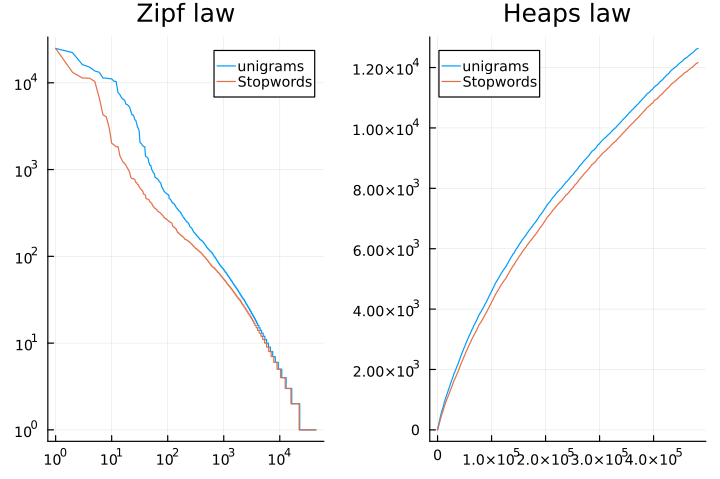

In [12]:
struct StopwordsTransformation <: AbstractTokenTransformation
    stopwords::Set{String}
    function StopwordsTransformation()
        tc = TextConfig(del_diac=true, lc=true)
        new(tokenize(tc, join(stopwords(Languages.Spanish()), ' ')) |> Set)
    end
end

function TextSearch.transform_unigram(S::StopwordsTransformation, tok)
   tok in S.stopwords ? nothing : tok
end

sw = text_model_and_vectors(D.corpus, group_usr=true, group_url=true, group_num=true, del_diac=true, lc=true, nlist=[1], tt=StopwordsTransformation())
compare(D, Q, unimodel, sw, "unigrams", "Stopwords", "Stopwords effect") |> display



### Filtrado estadístico

Las stopwords son las palabras más frecuentes, mientras que los errores ortográficos estarán en la cola de la distribución Zipfiana.
Una opción más agnóstica que el borrado de stopwords o corrección de errores, ya que requiere menos conocimiento de un lenguaje, es el filtrar términos por sus estadísticas.

A continuación se realiza un corte por frecuencia mínima y máxima.


<h1>no head and no tail effect</h1>
<div><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAHfCAIAAAD2i3iDAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdd1wTydsA8NlNqKGjVFHpiBQREMUCCihYAPWwYDsrdrGd9axnl7Me9rOcBRuKHQWxYUMUrCBFBOm9Q5Ldff/Y9/aXA1RKQgI83z/8ZGcns08Ws3l2dnYWoygKAQAAAACIEi7uAAAAAADQ+rHFHQAQssrKym/fvmEYZmRkJJQGS0tLc3NzEUIaGhoKCgrfq5aSksLj8bS0tBQVFYWyXQAAEKKvX79yuVxNTU0lJSVxx9JGYXBJRWJlZGTcuHGjnpVnzJhBv7h//76Li4uUlBSXy23K1rlc7po1a44fP56Tk0OXnDt3bsyYMd+rr6+vn5KScurUqQkTJjRluwAAUQgLC0tLS9PW1nZ3d6+zwtevX+/fv48Q8vHx+cGpRctlZmYWHx9/5MiRadOmiTuWNgp6OCRXXFycn59fPSszCYewrFix4s8//8QwzNbWVlVVFSGkpaUl3E0AAJrN7t27b9686eTk9L2EIyoqasqUKQih/v37t8qEA4gdJBySS0NDw8fH5wcVioqK7t27hxDS1dVlCtu3b+/t7S0lJdWUTfP5/MOHDyOEDhw4UP+kBwAAAPgeSDgkl4WFxYULF763liRJT09PhJCsrGxwcDBTbmlpeeXKlSZu+uvXr2VlZQihwYMHN7EpAAAAAEHC0XKtWLHi5s2bCKH9+/f36NGjQe/l8/lZWVnl5eWdO3eWkZGpXaG8vJx+Iaye1YqKirS0NDabraurKysrK5Q2AQDNLDs7u6CgQFFRUVdXF8OwH9Ssrq7OyMjg8XiamprKysr1aby6ujo9PR3DMD09PTb7R79NJSUlGRkZCgoK6urqcnJyDfsM31FZWZmWlobjuK6urrDaBDXAbbEt0uXLl3fs2IEQWrhw4dSpUwVXPX/+3NjYuGvXroKFJ0+eNDQ0HDJkCEEQGzdu1NXV1dPTMzMzU1NTmzZtWn5+PlMzNDSUrkkvdu/e3dDQ0NDQ0NfXtxFx3rx5c/Lkydra2hwOx8zMzMjISElJyc3N7cmTJzVq9u7d29DQsMYg2fDwcHrrmzZtEizPy8ujy798+dKIqAAADVJWVrZu3brOnTtraWmZm5vr6enp6OisXbu2srKyRs2oqKj58+ebmJjIysoaGBiYmpqqqanZ2tqeP3++drMrV640NDRctGhRaWnprFmz2rVrZ2hoaGBgoKmp+fvvv1dXV9eoX1hYOG/evPbt2ysrK3fp0kVPT09eXt7MzGzx4sWN/mihoaFTp07V1dWVl5c3NTU1NjZWUlIaMGDAgwcPatR0dnY2NDSs0X/8+PFj+li0du1awfLi4mIjIyNDQ8P4+PhGx9YKUaCliYmJ4XA4CCEXFxcej1djbXh4OEJISkpKsHDPnj0IISsrq3HjxiGE9PX1PTw8bGxs6P8D5ubmeXl5dM07d+4YGBh06NCBXtW5c2cDAwMDA4OxY8f+OKrOnTsjhE6dOiVY2K1bN4SQnJycmZnZgAEDunbtKi0tjRBis9kXL14UrDl27FiE0OzZswULmeOIra2tYDl9pUlTU5MkyXrsMAAARZ9FODk5fa/CxYsX6a/bly9fBMvT09MtLCzoVXp6ev369TMwMKC7N3r16lVWViZYedKkSQghaWlpAwMDJyen7t27M72k69atq7HF6dOnI4R8fHzs7OwQQpaWlh4eHsbGxnR9d3d3LpfLVK6oqGDCsLCw8PDw6Nu3r76+Po7jCgoK9dkDpqamCKEjR44IFjo4OCCEZGVlTU1N+/fvb2FhQXf6slisM2fO1P5oU6dOFSxcuXIlE5JgeUhICEJIXV2dIIj6xNZGQMLRwuTl5RkYGNCpQG5ubu0KP0g42Gw2hmH79u1jfqcjIiLo3k5fX1/B+rGxsfS3qKCgoJ6B1ZlwLF269OrVq4JZ0bdv3+iRsCoqKiUlJUz50aNHEUImJiaCb6dTIg6Hg+M4kxJRFEWPYx03blw9YwMANC7h4PF4vXr1Qgh16dLl9evXTHlUVBR9WjJz5kzBRnbt2vX3338LZiElJSW//fYbQgjH8bdv3wpWphMONpstLy9/+/Ztpvzvv/9msVgIoS1btjCFBw8eRAi1b99eMAyKolJSUrZv316fPVBnwrFixYrg4GDBzCYjI4M+/1FUVCwsLGTK//nnH4RQp06dBN9O5yscDgfDsIyMDKZ8/vz5dC5Vn8DaDkg4WhIul9u/f3+EkIKCQo2vLuMHCUftowP177cIw7CEhASmUFgJR514PB6dMwlWTklJobeYkpJCl+Tl5dHXUydOnIgQEuwRoec0+/vvv+sZGwCATjhwHJf/DmY4l2DCcfbsWfqAk5qaWqPBR48e0Z0ZWVlZP936sGHDEEKLFy8WLKQTDoRQYGBgjfpLly6lewgqKyvpklmzZiGEpk2b1ojPTqsz4agTn883MzOrUTk9PZ2OljlUFhUVsVgsDQ0NemKP06dPM5Xpi9oHDx5sdLStEozhaEn8/f0jIiIwDDt27JilpWUjWpg3b16NkrFjx2poaFD/9gE2Azab3bdvX4RQVFQUU9ipUyc6C6GnHkIIhYeHkyTp6urq4uJCL9LlqampiYmJCCE69wIA1B9JkhXfUXvMBELo9OnTCCEvLy89Pb0aq/r27duxY0cul8t8Z3/A2dkZ/fcrz1BQUJg8eXKNwgULFmAYlp+f//jxY7qkXbt2CKHY2Fgej/fTzTURi8Xq168f+m/AOjo6Xbp0QQLHogcPHhAEMWDAAFdXV8Hy7Ozsjx8/IoToYxdgwF0qLcbJkycDAwMRQqtWrRo1alQjWpCWlqbTdkEsFsvCwuL+/fsxMTFCiLKWxMTEM2fOvHz5Mjs7u7CwkC6kh6kyc5jSXFxckpOTw8PD6aMP/e11cXGhv7RhYWF0NfqFsbEx3acCAKi/Xr16MZdOarh582btSXeeP3+OEFJWVma+gILU1dVTU1MTEhIEC3Nycs6cORMZGZmSklJaWsrn8xFC9G329EMSaqBHmNYo1NXVbdeuXW5u7ps3b9zc3BBCQ4YM2bRpU1RUlJmZ2cSJE93c3Gxtbeu8ya6hkpOTz5w58+LFi6ysrKKiIoqiEEIFBQWormPUp0+fwsPD6R3FHKNcXV1xHL979y5dLSwsjKKojh07Cuv5Eq0GJBwtw7Nnz+j/4u7u7uvWrWtcI7q6ujheR58Wfe5S57GgiXbu3Lly5UrmjERJSUlFRYW54a3GGZWLi8uRI0fo7yqGYfSXecCAATo6OmZmZnFxcSkpKZ07d2a+5EKPFoBWT1paWnCeQEFqamo1Sng8Hv27GxgYSJ/t1KmkpIR5HRISMmnSpOLiYnpRXl5eVVWVSQuqqqpqv7123wmtY8eOubm5eXl59KKDg8OBAwcWL16cnJy8bt26devWcTicgQMHTpo0ycvL63ux/dTevXuXLl3KPAhCUVFRVVX1B8eo/fv3379/nyRJHMeZY5G6urqlpWVsbOznz59NTEzgGPU9kHC0AJmZmT4+PtXV1aampkFBQfRwqkYgCOIH5Y1u9nvCwsKWLl2KYZi/v//EiROtrKyYTSxcuHD37t016ru4uOA4TvdGKioqJiUlmZub0wdHV1fXuLi4+/fvT548OSIiAsGXGQDRI0mSfjFx4kRzc/PvVbO3t6dfpKamjh07trKy8pdffpkzZ46joyN9VxpC6MSJE7Wvm9C+d1yiu0YEj0szZswYPnx4SEjIrVu3Hj16lJ+ff+XKlStXrgwfPvz8+fONmF758ePH/v7+FEXNnTv3119/tba2ZlKN5cuXb9u2rUZ9Z2dnFouVn58fGxurpaX16dMnQ0NDfX19hJCrq2tsbGx4eLiJiQkco74HEg5JV1VVNXz48PT0dCU
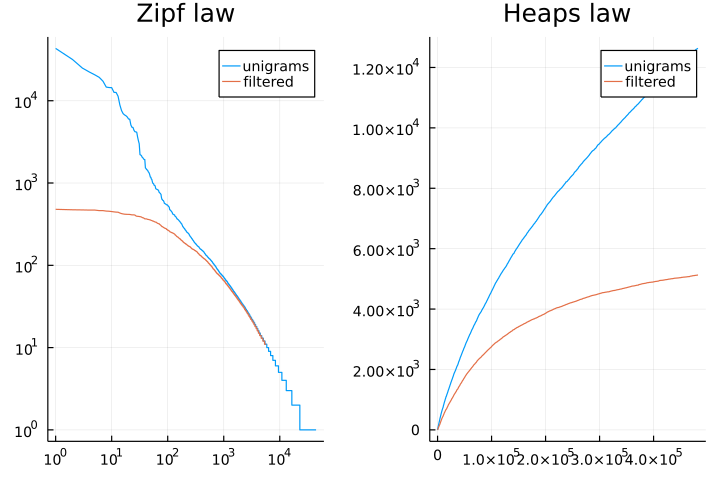

In [12]:
Fmodel = filter_tokens(unimodel.model) do t
    10 < t.ndocs < 500
end

F = text_model_and_vectors(D.corpus, model=Fmodel, textconfig=unimodel.textconfig)

compare(D, Q, unimodel, F, "unigrams", "filtered", "no head and no tail effect")

# Sobre los costos de búsqueda

Los algoritmos ayudan mucho, pero como se puede ver en los ejemplos, el desempeño es dependiente de relaciones entre el vocabulario y la colección.

En particular, la idea es que las filas de la matriz $W^*$ esten poco pobladas pero esto deberá lograrse de tal forma que la calidad no se vea comprometida. Por ejemplo, en los ejemplos se puede ver que las filas pueden hacerse pequeñas al considerar bigramas y seguramente será más si se usan trigramas, etc. Sin embargo, también podría ser que sea muy complicado recuperar siquiera documentos si la colección es pequeña, ya que será poco probable que n-words de tamaño considerable ocurran.

Por otra parte, controlar la cola de la distribución Zipf del vocabulario también puede asociarse con la corrección de errores o palabras creadas ad-hoc para el documento, que podrían no tener significado, incluso para una búsqueda muy especializada.

En general, podemos decir que siempre hay que evaluar el desempeño y calidad para una tarea dada, y ajustar a las necesidades del sistema y capacidades de los equipos de computo que operen.

# Actividades
- Si usa Julia, revise el paquete <https://github.com/sadit/TextSearch.jl>, <https://github.com/JuliaText/Languages.jl>, <https://github.com/JuliaText/Snowball.jl>.
- Si usa Python revisar `gensim`, `nltk`, y `sklearn` para preprocesamintos, tokenización y pesado.
- Reproduzca el ejercicio de este notebook, si usa Julia, utilice otro conjunto de datos de los disponibles.
- Implementa el pesado TF IDF con términos de suavisado.
- Reporte un notebook de Jupyter con una comparación de tiempos y curvas Zipf y Heaps para los diferentes tratamientos. Anote sus reflexiones sobre los modelos de datos, dominios y los alcances de los algoritmos.

# Bibliografía
- [SMR2008] Schütze, H., Manning, C. D., & Raghavan, P. (2008). Introduction to information retrieval (Vol. 39, pp. 234-65). Cambridge: Cambridge University Press.
- [BYN1999] Baeza-Yates, R., & Ribeiro-Neto, B. (1999). Modern information retrieval (Vol. 463). New York: ACM press.
